In [3]:
from collections import Counter
from itertools import chain
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk import pos_tag, ne_chunk, Tree
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

## Data Preparation

In [4]:
bipolar_df = pd.read_csv('../data/RedditBipolar.csv', encoding='latin9', delimiter=';', parse_dates=['date'])
bipolar_df = bipolar_df[['date', 'author', 'post']]
bipolar_df.head()

,date,author,post
0,01/01/2018,TanagerOffTrack,What birth control are you on? I tried an IUD ...
1,01/01/2018,DuplicitousSnake,Hypersexuality I was diagnosed with bipolar un...
2,01/01/2018,dearangelou,Meditation I have been using the free meditati...
3,01/01/2018,dootdoopdooq,Family question diagnosis - vent Start with th...
4,01/01/2018,lemonyellow3,Unable to stop talking to myself- any ideas/ex...


In [5]:
print(bipolar_df.shape)
print(bipolar_df['post'].nunique())
print(bipolar_df['author'].nunique())
print(bipolar_df.info())

(1692, 3)
1692
1618
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1692 non-null   object
 1   author  1692 non-null   object
 2   post    1692 non-null   object
dtypes: object(3)
memory usage: 39.8+ KB
None


## Text Preprocessing

### Tokenization

In [6]:
bipolar_df['post_tokens_uppercase'] = bipolar_df['post'].apply(lambda x: nltk.word_tokenize(x))



### Stop word removal

In [7]:
stop_words = stopwords.words('english')
stop_words = stop_words + ['make', 'feel', 'like', 'going', 'thing', 'something', 'get', 'http', 'else', 'anyone', 'bipolar', 'disorder']

bipolar_df['post_tokens_lowercase'] = bipolar_df['post_tokens_uppercase'].apply(
  lambda x: [word.lower() for word in x if word.lower().isalpha() and word.lower() not in stop_words]
)

### POS tagging

In [8]:
bipolar_df['post_tokens_uppercase_with_pos_tags'] = bipolar_df['post_tokens_uppercase'].apply(pos_tag)

### Named entity recognition

In [9]:
def extract_named_entities(tree):
  entities = []
  for node in tree:
    if isinstance(node, Tree): # instance of nameed entity
      entity_type = node.label()
      entity_words = " ".join(word for word, _ in node.leaves())
      entities.append((entity_words, entity_type))
  return entities

In [10]:
bipolar_df['named_entities'] = bipolar_df['post_tokens_uppercase_with_pos_tags'].apply(
    lambda tagged: extract_named_entities(ne_chunk(tagged))
)


### Lemmatization

In [11]:
def map_pos_tags(tag: str):
  if tag.startswith('J'):
      return 'a'
  elif tag.startswith('V'):
      return 'v'
  elif tag.startswith('R'):
      return 'r'
  return 'n'

In [12]:
wnl = WordNetLemmatizer()

bipolar_df['post_lemmas_lowercase'] = bipolar_df['post_tokens_lowercase'].apply(lambda x: [wnl.lemmatize(word) for word in x])

bipolar_df['post_lemmas_uppercase'] = bipolar_df['post_tokens_uppercase_with_pos_tags'].apply(
  lambda tagged: [wnl.lemmatize(word=word, pos=map_pos_tags(tag)) for word, tag in tagged]
)

## Exploratory Analysis

### Word frequency analysis

In [13]:
all_lemmas = list(chain.from_iterable(bipolar_df['post_lemmas_lowercase']))
word_count = Counter(all_lemmas)

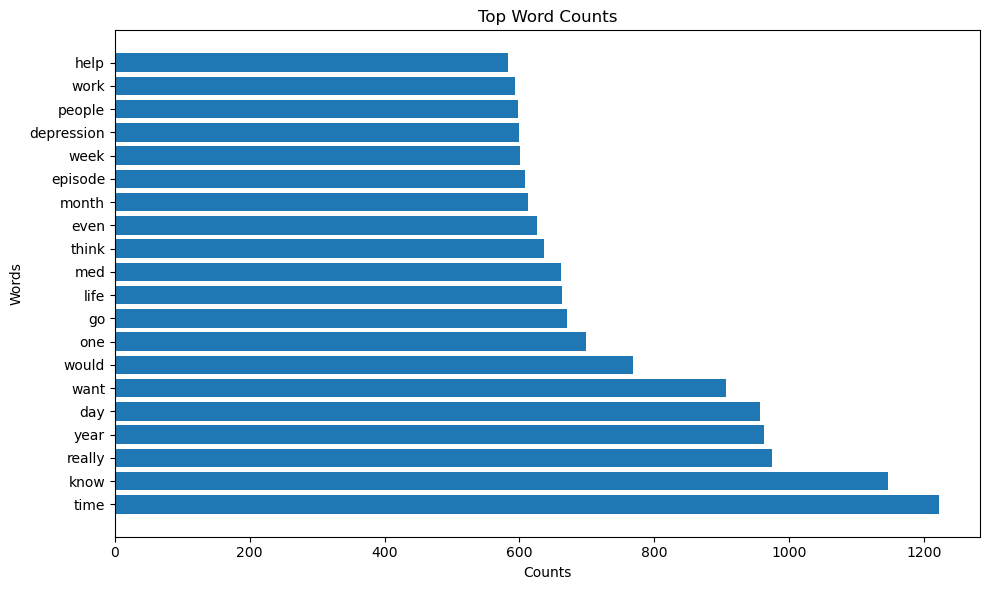

In [14]:
top_words = word_count.most_common(20)

words, counts = zip(*top_words)

plt.figure(figsize=(10, 6))
plt.barh(words, counts)
plt.title('Top Word Counts')
plt.xlabel('Counts')
plt.ylabel('Words')
plt.tight_layout()
plt.show()

### Word clouds

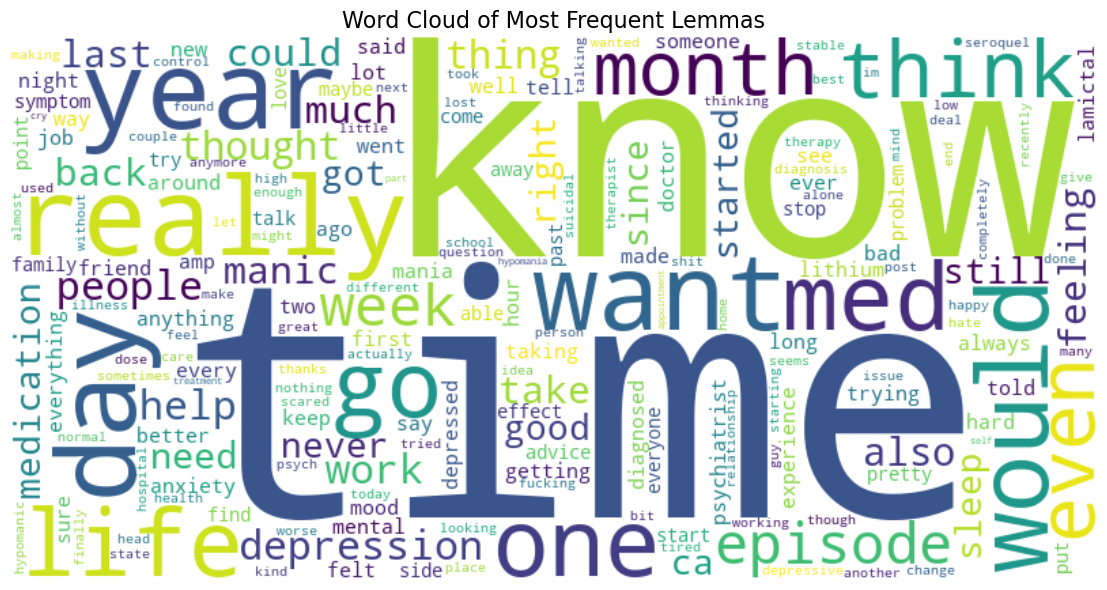

In [15]:
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_count)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Frequent Lemmas", fontsize=16)
plt.tight_layout()
plt.show()

### Top entities overall

In [16]:
all_entities = list(chain.from_iterable(bipolar_df['named_entities']))
all_entities = [word for word, _ in all_entities]
entity_counts = Counter(all_entities)

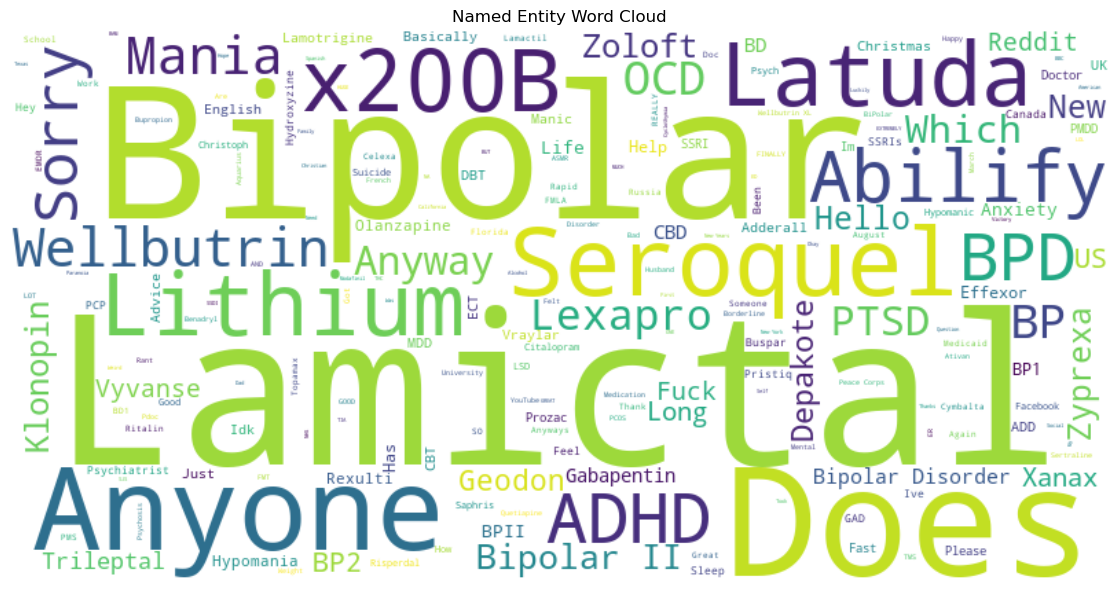

In [17]:
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(entity_counts)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.title('Named Entity Word Cloud')
plt.axis('off')
plt.tight_layout()
plt.show()

### Sentiment analysis

In [18]:
# bipolar_df = bipolar_df.drop(['compound', 'pos', 'neg', 'neu'], axis=1)

In [19]:
sia = SentimentIntensityAnalyzer()

# generates a dictionary of normalized scores (neg, neu, pos, compound)
bipolar_df['sentiment'] = bipolar_df['post'].apply(sia.polarity_scores)

# creates a dataframe from json
sentiment_df = pd.json_normalize(bipolar_df['sentiment'])

# concatenates the bipolar_df and sentiment_df columns
bipolar_df = pd.concat([bipolar_df, sentiment_df], axis=1)

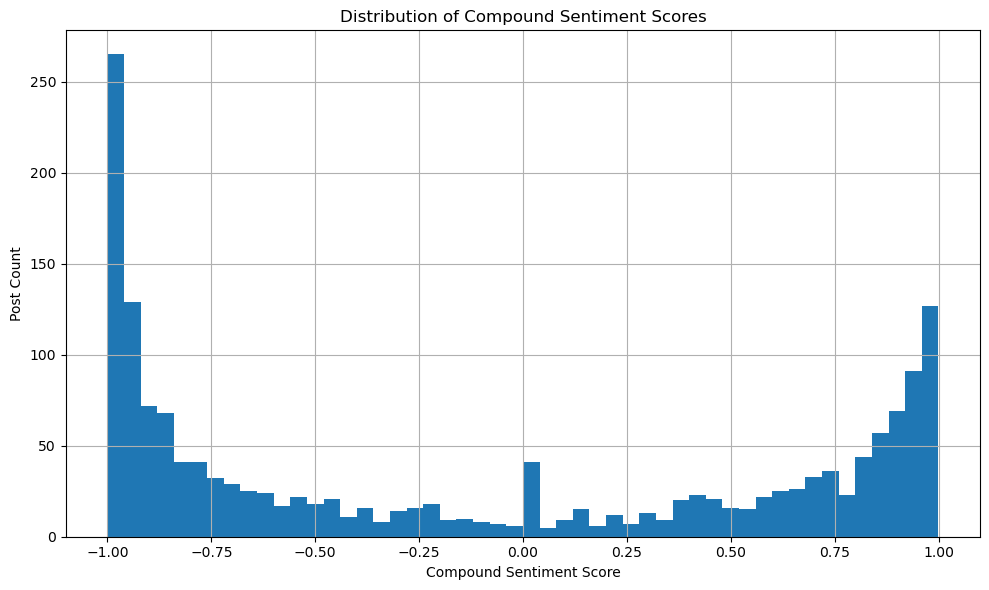

In [20]:
plt.figure(figsize=(10, 6))
plt.hist(bipolar_df['compound'], bins=50)
plt.title('Distribution of Compound Sentiment Scores')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Post Count')
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
def label_sentiment(x: float):
  if x <= -0.05:
    return 'Negative'
  if x >= 0.05:
    return 'Positive'
  return 'Neutral'

bipolar_df['sentiment_label'] = bipolar_df['compound'].apply(label_sentiment)
bipolar_df['sentiment_label'].value_counts(normalize=True)

sentiment_label
Negative    0.543735
Positive    0.427305
Neutral     0.028960
Name: proportion, dtype: float64

## Topic Modeling

### TF-IDF matrix

In [22]:
def lemmas_to_string(lemmas: list[str]):
  return ' '.join(lemma for lemma in lemmas)

bipolar_df['post_lemma_string_lowercase'] = bipolar_df['post_lemmas_lowercase'].apply(lemmas_to_string)

tfidf_vectorizer = TfidfVectorizer(
  ngram_range=(2, 3),
  min_df=5,
  max_df=0.95,
  stop_words=stop_words
)

X_tfidf = tfidf_vectorizer.fit_transform(bipolar_df['post_lemma_string_lowercase'])

### Non-Negative Matrix Factorization (NMF)

In [23]:
n_components = 10

model = NMF(
  n_components=n_components,
  init='random',
  random_state=42,
  max_iter=1000
)

W = model.fit_transform(X_tfidf) # document-topic matrix → each row shows how much each topic contributes to a post
H = model.components_ # topic-term matrix → each row is a topic, each column a term

In [24]:
feature_names = tfidf_vectorizer.get_feature_names_out() # Gets the words from the tf-idf vector

for topic_idx, topic in enumerate(H): # for loop to map the top columns in the H matrix to their corresponding words in the feature_names
  top_indices = topic.argsort()[::-1][:10] # reverse sort the top ten indices according to their topic weights
  top_words = [feature_names[i] for i in top_indices] # retrieve the feature names for the top ten indices
  print(f'Topic {topic_idx+1}: {", ".join(top_words)}') # print the n-grams corresponding to each topic

Topic 1: year ago, first time, month ago, last year, even though, year old, two year, last week, go back, started taking
Topic 2: last night, really think, dont know, started lithium, night sleep, sleep last, racing thought, know nothing, woke morning, night one
Topic 3: side effect, working really, side effect med, effect med, want take, want start, experience lithium, weight gain, know experience, really well
Topic 4: mental illness, every day, think ever, almost every, multiple time, guy ever, full time, depression anxiety, major depression, deal mental
Topic 5: depressive episode, rapid cycling, bad depressive episode, bad depressive, greatly appreciated, episode know, would greatly, major depressive, really bad, recently diagnosed
Topic 6: manic episode, episode last, mood stabilizer, high school, loved one, long term, week two, mania depression, ever experienced, full blown
Topic 7: mood swing, racing thought, manic depressive, go manic, pretty sure, gotten worse, even know, long

### LDA

In [25]:
count_vectorizer = CountVectorizer(
  ngram_range=(2, 3),
  min_df=5,
  max_df=0.95,
  stop_words=stop_words
)

X_count = count_vectorizer.fit_transform(bipolar_df['post_lemma_string_lowercase'])

In [26]:
n_components = 10

lda = LatentDirichletAllocation(
  n_components=n_components,
  random_state=42,
  max_iter=50
)

lda.fit(X_count)

,n_components,10
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,50
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


In [27]:
feature_names = count_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
  top_indices = topic.argsort()[::-1][:10]
  top_words = [feature_names[i] for i in top_indices]
  print(f'Topic {topic_idx + 1}: {", ".join(top_words)}')

Topic 1: last year, long time, mental health, depressive episode, panic attack, manic phase, two week, last week, want go, hard time
Topic 2: new year, last night, manic episode, last time, full time, stop taking, mental health, two week, got ta, time job
Topic 3: first time, rapid cycling, depressive episode, need help, next week, health insurance, side effect, gon na, manic episode, mood swing
Topic 4: side effect, taking med, recently diagnosed, weight gain, mood stabilizer, taking lithium, year ago, med change, started taking, stopped taking
Topic 5: depressive episode, last year, manic episode, go away, every day, year ago, wan na, long time, good day, every single
Topic 6: side effect, manic episode, dont know, long story, story short, long story short, mood stabilizer, every day, year ago, birth control
Topic 7: manic episode, depressive episode, month ago, first time, year old, last week, mixed episode, year ago, week ago, panic attack
Topic 8: manic episode, go back, even thou

### Top Posts and Sentiment per Topic

In [28]:
def get_top_posts(topic_idx: int, n_posts: int):
  topic_scores = W[:, topic_idx]
  top_indices = topic_scores.argsort()[::-1][:n_posts]
  return (pd.concat([bipolar_df.iloc[top_indices]['post'], sentiment_df.iloc[top_indices]['compound']], axis=1))

for i in range(n_components):
  posts = get_top_posts(i, 5)
  print(f'Topic {i}:')
  print(f"{posts.apply(lambda x: 'Sentiment: ' + str(x['compound']) + '  Content: ' + str(x['post']), axis=1)}")
  print('\n')

Topic 0:
432     Sentiment: 0.0  Content: Bipolar weightlifting...
1640    Sentiment: 0.9444  Content: Is it my disease o...
1186    Sentiment: -0.659  Content: Lost my way, cons...
152     Sentiment: -0.9701  Content: My Checkup Was A ...
376     Sentiment: 0.1027  Content: Lithium and loss o...
dtype: object


Topic 1:
959     Sentiment: -0.8944  Content: Topamax side effe...
43      Sentiment: -0.128  Content: I had two beers la...
1260    Sentiment: 0.829  Content: I feel my mood esca...
1211    Sentiment: 0.8436  Content: Can cold meds make...
37      Sentiment: -0.5707  Content: No sleep I didnt...
dtype: object


Topic 2:
793    Sentiment: -0.2144  Content: Seroquel side eff...
285    Sentiment: 0.966  Content: Started Trileptal. ...
635    Sentiment: -0.4247  Content: I'll be without l...
494    Sentiment: -0.9067  Content: Prozac and period...
949    Sentiment: 0.5197  Content: Rexulti experience...
dtype: object


Topic 3:
372     Sentiment: -0.685  Content: Essay about liv

## Clustering and Classification

### Group posts by linguistic similarity

### KMeans clustering

### DBSCAN

### Classify posts by manic or depressive tone